In [1]:
import math
import random
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# Obliczanie pola koła metodą Monte Carlo

Losując punkty wewnątrz kwadratu opisanego na kole i sprawdzając ile % z nich leży wewnątrz koła otrzymamy pzybliżoną wartość pola koła
W analogiczy sposób można obliczyć wartości skomplikowanych całek oznaczonych

In [3]:
r = 2

def pk_mc(r,n=1000):
    # pole kwadratu
    pk = (2 *r)**2
    # liczba punktów w kole
    nk = 0 
    for i in range(n):
        #w każdej iteracji losujemy współrzędną x i y z przedziału (-r,r)
        los_x = random.uniform(-r,r)
        los_y = random.uniform(-r,r)
        #sprawdzamy czy współrzędna (los_x,los_y) leży wewnątrz koła
        if los_x **2 + los_y**2 <= r **2:
            nk+=1 
    
    pole_mc = pk * (nk/n)
    pole_wzor = math.pi * r**2
    print('Pole wg wzoru:{0}\nPole metodą Monte Carlo:{1}, n={2}'.format(pole_wzor,pole_mc,n))
    

In [16]:
pk_mc(r,n=100000)

Pole wg wzoru:12.566370614359172
Pole metodą Monte Carlo:12.57664, n=100000


# Metody Mone Carlo moży użyć by zwększyć wiarygodność testu statystycznego

Jeżeli mamy dane z jaiejś probki, zawsze musimy pamiętać, że to tylko próbka - cała populacja może wyglądać inaczej. Pewne dane mogły nam się ułożyć przypadkowo.
Dlatego też można stosować metodę bootstrapu, czyli losowania ze zwracaniem - dzięki temu za każdym razem nasza wylosowana próbka jest trochę inna i dzięki temu możemy lepiej zabezpieczyć się przed przypadkowością pobrania próbki.




In [17]:
crime = pd.read_csv('data/boston_crime.csv', engine='python')
crime.head()
# obliczamy liczbę przestępstw kradzieży w każdym dniu
daily = crime.groupby(['date','DAY_OF_WEEK']).count()['INCIDENT_NUMBER'].reset_index()

In [18]:
daily.groupby('DAY_OF_WEEK').mean()

,INCIDENT_NUMBER
DAY_OF_WEEK,
Friday,22.800000
Monday,21.507143
Saturday,21.235714
Sunday,17.921429
Thursday,22.302158
Tuesday,22.244604
Wednesday,21.956835


Chcemy zbadać czy średnia liczba przestępstw w piatki jest istotnie wyższa niż w soboty

In [19]:
x = np.array(daily.loc[daily['DAY_OF_WEEK'] == 'Friday' ]['INCIDENT_NUMBER'])
y = np.array(daily.loc[daily['DAY_OF_WEEK'] == 'Saturday' ]['INCIDENT_NUMBER'])

print(ttest_ind(x,y))

Ttest_indResult(statistic=2.3490465606892728, pvalue=0.019521699391858525)


p-value testu wyszło nam mniejsze niż 0.05 więc wg testu różnica jest istotna

Ale mimo to mamy na uwadzę, że dane mogą się trochę różnić od rzeczywistości oraz wiemy że dysponujemy tylko pewną liczbą dni chcemy się upewnić. Dlatego przeprowadzimy symulację

In [20]:
def test_bootstrap(x,y,n=1000,alpha=0.05):
    pvalues= []
    for i in range(n):
        # losujemy ze zwracaniem wektory
        sample_x = np.random.choice(x,len(x),replace=True)
        sample_y = np.random.choice(y,len(y),replace=True)
        #test t-studenta
        tst = ttest_ind(sample_x,sample_y)
        # czy wynik jest istotny
        p = (tst.pvalue < alpha)*1
        pvalues.append(p)
        
    print('Wynik testu istotny w {0} symulacji'.format(  "{:.1%}".format(np.mean(pvalues) )))

In [21]:
test_bootstrap(x,y)

Wynik testu istotny w 64.8% symulacji


Z symulacji wyszło nam że tylko w ok 65% przypadków wynik jest istotny więc wniosek z tego taki, że nie możemy z przekonaniem stwiedzić, że w piątki jest więcej przstepstw niż w soboty

Możemy też do symulacji dodać jakieś dodatkowe czynniki. W przykłdzie takim czynnikiem będzie to, że wiemy że część zaraportowanych przestepstw tak naprawdę nastąpiła dzień wcześniej - więc wg naszych danych w danym dniu możeby być w wiecej lub mniej zaraportowanych przestepstw niż rzeczyiście

Założymy, że tą różnicę będzie charakteryzować zmienna losowa, będąca zaokrągleniem liczby z rozkładu normalnego

In [24]:
def test_symulacja(x,y,xm,y_m,xs,ys,n=1000,alpha=0.05):
    #xm,xs - śrdnia i odchylenie rozkałdu normalnego charakteryzująca różnicę zaraportowanych przestępstw dla piątku
    #ym,ys - analogicznie dla soboty
    pvalues= []
    for i in range(n):
        #dodajemy wylosowane różnice
        sample_x = x + np.random.normal(xm,xs,len(x)).round()
        sample_y = y + np.random.normal(y_m,ys,len(y)).round()
        tst = ttest_ind(sample_x,sample_y)
        p = (tst.pvalue < alpha)*1
        pvalues.append(p)
    print('Wynik testu istotny w {0} symulacji'.format(  "{:.1%}".format(np.mean(pvalues) )))

In [25]:
test_symulacja(x,y,0,0.2,1.5,1.2)

Wynik testu istotny w 52.8% symulacji


# Symulacja Monte Carlo przewidująca różn scenariusze na przykładzie predykcji ceny indeksu giełdowego

Za pomocą symulacji będziemy chcieli przewidzeć cenę indeksu WIG20 
Weźmiemy dane historyczne i sprawdzimy rozkład dziennych stop zwrotu 
Nastepnie na podstawie tego rozkładu spróbujemy wygenerować scenariusze jak indeks może się zachować


In [28]:
wig = pd.read_csv('data/wig20_d.csv')

zam = wig['Zamkniecie']
#Obliczamy dzienne stopy zwrot
wig['stopa'] = [ 0 if i==0 else (zam[i]-zam[i-1])/zam[i-1]   for i in range(len(zam))]

#Bieżemy dane z okresu 2015 -2019, spróbujemy zasymulować cenę na koniec 2019 roku
train_data = wig.loc[ (wig['Data'] >= '2015-01-01') & (wig['Data'] < '2019-01-01')  ]
m = np.mean(train_data['stopa'])
sd = np.std(train_data['stopa'])

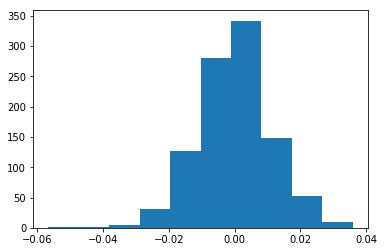

In [38]:
plt.hist(train_data['stopa']);

Założymy że dane są z rozkładu normalnego 

In [31]:
#Tworzymy trajektorę:
#startujemy w danym punkcie i następny dzień będzie różnić się od poporzedniego o wylosowaną liczbę z rozkłądu normalnego
def trajektoria(start,n,m,sd):
    dzien = 1
    trajektoria = []
    for d in range(n):
        dzien = dzien + np.random.normal(m,sd)
        trajektoria.append(dzien)
    return np.array(trajektoria) * start

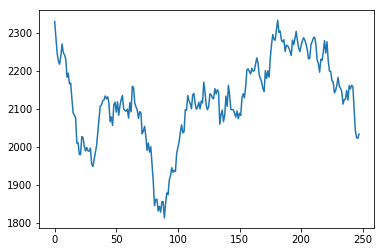

In [49]:
st = float(wig.loc[wig['Data']=='2019-01-02']['Zamkniecie']) # wartość początkowa 0 pierwszy dzień giełdowy w 2019
tst_data = wig.loc[ (wig['Data'] >= '2019-01-01') & (wig['Data'] <= '2019-12-31')  ] 
#liczba dni notowań w 2019
n = len(tst_data)
#Rysujemy pojedynczą trajektorię
t = trajektoria(st,n,m,sd)
plt.plot(t);

Tak wygląda przykłądowy scenariusz.
Teraz metodą Monte Carlo będziemy generować n scenariuszy.
Na ich podstawie wyliczymy średnią i dchylenie możliwych wartości na koniec 2019 roku

In [33]:
def symulacja(start,n,m,sd,n_symul):
    wynik = []
    for i in range(n_symul):
        tr = trajektoria(st,n,m,sd)
        wynik.append(tr[-1])
    return wynik

rozklad_wynik = symulacja(st,n,m,sd,10000)  

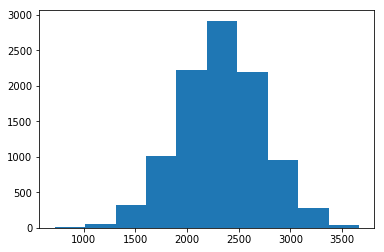

In [37]:
plt.hist(rozklad_wynik);

In [35]:
real = float(wig.loc[wig['Data']=='2019-12-30']['Zamkniecie'])

wynik_m = np.mean(rozklad_wynik)
wynik_sd = np.std(rozklad_wynik)

print('Wg symulcji Monte Carlo cena wynosi {0} +- {1} a wartoc realna to {2}'.format(wynik_m,wynik_sd,real))

Wg symulcji Monte Carlo cena wynosi 2327.6814045463516 +- 400.1467093985798 a wartoc realna to 2150.09
